# Downloading

Download raw lfp

#### Setup

create and activate env from `allensdk.txt`


In [1]:
%load_ext autoreload
%autoreload 2

import os
import json 
from pathlib import Path
import numpy as np

# move to project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.dataeng.allen import allen

# SETUP PARAMETERS
EXPERIMENT = "supp/allen_neuropixels"  # the experiment 
SIMULATION_DATE = "2023_08_30"    # the run (date)
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()
RAW_DATA = data_conf["raw_data"]["input"]
DOWNLOAD_COMPLETE_DATASET = True
manifest_path = os.path.join(RAW_DATA, "manifest.json")

# session data with optotagged parvalbmin interneurons (reliable laser)
# 1.82 GB
PARV_SESSION_ID = 829720705
PARV_PROBE_ID = 832129154 # there are 5 in this session. We take the first.

# session data with optotagged somatostatin interneurons (reliable laser)
# 2.82 GB
SST_SESSION_ID = 839068429   

# session data with optotagged vip interneurons (reliable laser)
# 2 GB
VIP_SESSION_ID = 835479236

2023-09-06 18:03:28,917 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-06 18:03:28,924 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Download lfp trace from a probe of the session

In [3]:
# load cached (already downloaded) session (NWB file)
session = allen.download_data_from_a_session(PARV_SESSION_ID, manifest_path)

# list session's probe ids
probe_ids = allen.find_probes_in_visual_cortex(session, manifest_path)

2023-09-06 17:54:06,065 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:06,069 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:06,080 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:06,092 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:07,174 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:07,305 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:07,315 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:07,511 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06 17:54:07,634 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache
2023-09-06

In [4]:
# download PROBE_ID's lfp traces (NWB file)
parv_lfp = session.get_lfp(PARV_PROBE_ID)

2023-09-06 17:54:13,659 - call_caching - caching_utilities.py - call_caching - INFO - Reading data from cache


### Get lfp during spontaneous activity

total of 6 spontaneous stimuli periods, 2300-ish secs (40 min)

In [5]:
# get spike times from the first block of drifting gratings presentations
spontaneous_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations["stimulus_name"] == "spontaneous")
].index.values

# initialize false mask for all timepoints
mask = np.zeros((1, len(parv_lfp.time)), dtype=bool)

for spont_stim in spontaneous_ids:

    # get start and stop of this spontaneous stimulus
    start_time = session.stimulus_presentations.loc[spont_stim].start_time
    stop_time = session.stimulus_presentations.loc[spont_stim].stop_time

    # mask the lfp timepoints for this period (True)
    mask_i = (parv_lfp.time >= start_time) & (parv_lfp.time < stop_time)
    mask = np.sum([mask, mask_i.data], axis=0)

In [6]:
# unit-testing

# calculate total spontaneous duration from session data
duration = 0
for spont_stim in spontaneous_ids:
    duration += session.stimulus_presentations.loc[spont_stim].duration

# calculate the same from produced mask
tstep = parv_lfp.time[1] - parv_lfp.time[0]
duration_from_mask = np.sum(mask) * tstep.data

# test
assert np.round(duration * 1e4) == np.round(
    duration_from_mask * 1e4
), "duration should be equal"

In [7]:
# parv_lfp.data.shapea
spont_time = parv_lfp.time[np.where(mask.squeeze())[0]]

spont_lfp = parv_lfp.data[np.where(mask.squeeze())[0], :]

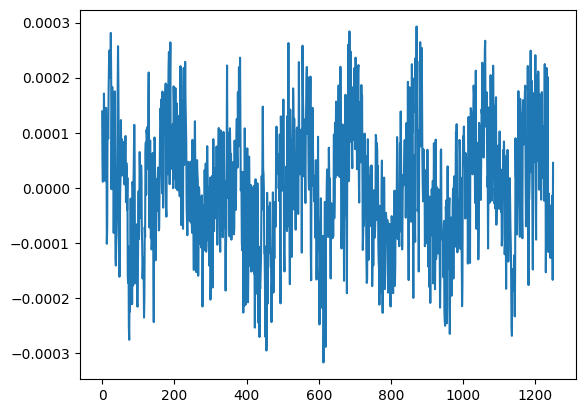

In [14]:
from matplotlib import pyplot as plt

plt.plot(spont_lfp[:1250, 0])

ModuleNotFoundError: No module named 'spikeinterface'

### References

https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html#Querying-across-probes